In [108]:
import os
import numpy as np
import pandas as pd
import torchaudio
import torchmetrics
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn, Tensor
import pytorch_lightning as pl
from pytorch_lightning.strategies import DDPStrategy
from pytorch_lightning.callbacks import (
    ModelSummary,
    ModelCheckpoint,
    EarlyStopping,
    Callback,
)
from pytorch_lightning.accelerators import find_usable_cuda_devices
from transformers import WavLMModel
from argparse import ArgumentParser

from speechbrain.lobes.models.ECAPA_TDNN import ECAPA_TDNN
from typing import Optional
import scipy.io.wavfile as wav
import json
from tqdm.notebook import tqdm

In [8]:
df = pd.read_csv('/data/users/athkulkarni/asvspoof2024/metadata.csv')
df.head()

,ID,fname,Gender,Placeholder,Attack_Type,Label,audio_lengths
0,T_4286,T_0000164932,F,-,bonafide,bonafide,10.030
1,T_1645,T_0000044731,F,-,bonafide,bonafide,12.400
2,T_0101,T_0000038212,F,-,bonafide,bonafide,10.910
3,T_5246,T_0000074852,M,-,bonafide,bonafide,14.190
4,T_1902,T_0000163941,M,-,A02,spoof,9.056


In [9]:

class SSLClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # self.example_input_array = torch.Tensor(5, 64600) # TODO Just an example to show the input shape
        ####
        # create network hubert base
        ####
        self.ssl_model = WavLMModel.from_pretrained("microsoft/wavlm-base")
        #self.ssl_model.requires_grad_(False)
        #for param in self.ssl_model.parameters():
        #    param.requires_grad = False
        #self.ssl_model.eval()
        self.ecapa_tdnn = ECAPA_TDNN(768, lin_neurons=192)
        self.classifier = nn.Linear(192, 2)

        # Activates manual optimization
        # self.automatic_optimization = False

        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        # -------pre-trained Wav2vec model fine tunning ------------------------##
        # print(x.shape)
        x_ssl_feat = self.ssl_model(x, output_hidden_states=True)
        x_ssl_feat = x_ssl_feat.last_hidden_state
        # print(x_ssl_feat.shape)
        # post-processing on front-end features
        x = self.ecapa_tdnn(x_ssl_feat)
        x = self.classifier(x.squeeze())
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        scores = self(x)
        weight = torch.FloatTensor([1.0, 9.0]).to(self.device)
        criterion = nn.CrossEntropyLoss(weight=weight)
        loss = criterion(scores, y)

        self.train_accuracy(torch.argmax(scores, 1), y)
        self.log_dict(
            {"train_loss": loss, "train_accuracy": self.train_accuracy},
            prog_bar=True,
            on_step=False,
            on_epoch=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        scores = self(x)
        weight = torch.FloatTensor([1.0, 9.0]).to(self.device)
        criterion = nn.CrossEntropyLoss(weight=weight)
        loss = criterion(scores, y)

        self.val_accuracy(torch.argmax(scores, 1), y)
        self.log_dict(
            {"val_loss": loss, "val_accuracy": self.val_accuracy},
            prog_bar=True,
            on_step=False,
            on_epoch=True,
        )
        return loss

    def test_step(self, batch, batch_idx):
        self._produce_evaluation_file(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
        return optimizer

    def _produce_evaluation_file(self, batch, batch_idx):
        x, utt_id = batch
        fname_list = []
        score_list = []
        out = self(x)
        scores = (out[:, 1]).data.cpu().numpy().ravel()
        fname_list.extend(utt_id)
        score_list.extend(scores.tolist())

        with open(args.eval_output, "a+") as fh:
            for f, cm in zip(fname_list, score_list):
                fh.write("{} {}\n".format(f, cm))
        fh.close()
        # print("Scores saved to {}".format(args.save_path))



In [93]:
##############Ignore############
################################

def apply_sliding_mask_with_stride(audio_path, mask_duration, sample_rate, stride=None):
    """
    Apply a sliding mask over the audio signal with specified stride.
    
    Args:
        audio_path (str): Path to the audio file.
        mask_duration (float): Duration of the mask in seconds.
        sample_rate (int): Sample rate of the audio signal.
        stride (float, optional): Stride duration in seconds. If None, stride equals mask_duration.
    
    Returns:
        List of masked audio segments.
    """
    audio_signal, sr = torchaudio.load(audio_path)
    audio_signal = audio_signal.squeeze(0).numpy()
    mask_length = int(mask_duration * sample_rate)
    
    # If stride is not specified, use mask_length as stride
    if stride is None:
        stride_length = mask_length
    else:
        stride_length = int(stride * sample_rate)
    
    masked_segments = []

    # Use stride_length instead of mask_length in the range step
    for start in range(0, len(audio_signal) - mask_length + 1, stride_length):
        masked_audio = np.copy(audio_signal)
        masked_audio[start:start + mask_length] = 0  # Apply zero mask
        masked_segments.append(masked_audio)
    
    return masked_segments

In [94]:
def apply_sliding_mask(audio_path, mask_duration, sample_rate):
    """
    Apply a sliding mask over the audio signal.
    
    Args:
        audio_signal (np.ndarray): Input audio signal.
        mask_duration (float): Duration of the mask in seconds.
        sample_rate (int): Sample rate of the audio signal.
    
    Returns:
        List of masked audio segments.
    """
    audio_signal, sr = torchaudio.load(audio_path)
    audio_signal = audio_signal.squeeze(0).numpy()
    mask_length = int(mask_duration * sample_rate)
    masked_segments = []

    for start in range(0, len(audio_signal), mask_length):
        masked_audio = np.copy(audio_signal)
        masked_audio[start:start + mask_length] = 0  # Apply zero mask
        masked_segments.append(masked_audio)
    
    return masked_segments

In [ ]:
def masked_inference(masked_segments, label, model):
    logits = []
    losses = []

    model.cuda()
    # weight = torch.FloatTensor([1.0, 9.0]).to('cuda')
    # criterion = nn.CrossEntropyLoss(weight=weight)
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for ms in masked_segments:
            model.eval()
            out = model(torch.tensor(ms).unsqueeze(0).cuda())
            scores = (out)

            if label is not None:
                loss = criterion(scores, torch.tensor(label).cuda())
                losses.append(loss.detach().cpu().numpy().tolist())

            # print(F.softmax(out, dim=-1))
            logit = out.data.cpu().numpy().ravel().tolist()
            
            logits.append(logit)

        return logits, losses
    

In [ ]:
def unmasked_inference(audio, label, model):
    with torch.no_grad():
        out = model(torch.tensor(audio).unsqueeze(0).cuda())
        scores = (out)

        criterion = nn.CrossEntropyLoss()

        logits = out.data.cpu().numpy().ravel().tolist()

        if label is not None:
            loss = criterion(scores, torch.tensor(label).cuda())
                
    return logits, loss

In [13]:
model = SSLClassifier.load_from_checkpoint('/data/code/SSL_antispoof_work/Wav2Vec2Ecapa/training_scripts_asvspoof_2019/results/wavlm_ecapa/best_model-epoch=40-val_loss=0.03205-val_accuracy=0.99489.ckpt')
model.eval()

Some weights of the model checkpoint at microsoft/wavlm-base were not used when initializing WavLMModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMModel were not initialized from the model checkpoint at microsoft/wavlm-base and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

SSLClassifier(
  (ssl_model): WavLMModel(
    (feature_extractor): WavLMFeatureEncoder(
      (conv_layers): ModuleList(
        (0): WavLMGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x WavLMNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x WavLMNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): WavLMFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): WavLMEncoder(
  

In [96]:
def inference(audio_paths, labels, model,  sampling_rate=16000, window_size = [1, 2, 3], stride=None):
    results_all = {}
    model.eval()
    for audio_path, label in tqdm(zip(audio_paths, labels), total=len(audio_paths)):

        results_sample = {}

        unmasked_logits, unmasked_loss = unmasked_inference(torchaudio.load(audio_path)[0].squeeze(0), label, model)
        softmax_probs = F.softmax(torch.tensor(unmasked_logits), dim=0)

        predicted_class_id = torch.argmax(softmax_probs).item()

        results_sample['predicted_class_id'] = predicted_class_id

        results_sample['unmasked_logits'] = unmasked_logits
        results_sample['unmasked_loss'] = unmasked_loss.detach().cpu().numpy().item()

        for ws in window_size:
            metrics_per_window = {}
            masked_segments = apply_sliding_mask_with_stride(audio_path, ws, sampling_rate, stride=stride)

            logits, losses = masked_inference(masked_segments, label, model)

            # Get the index of the class with the maximum probability
            
            metrics_per_window['logits'] = logits
            metrics_per_window['losses'] = losses

            metrics_per_window['variances'] = (np.abs(np.var(np.array(logits)[:, 0])), np.abs(np.var(np.array(logits)[:, 1])))
            results_sample[str(ws)] = metrics_per_window

        
            del masked_segments
        
        results_all[audio_path] = results_sample


    return results_all

In [91]:
fnames = [f'/data/users/athkulkarni/asvspoof2024/{i}.flac' for i in df.fname]
labels = [1 if i == 'bonafide' else 0 for i in df.Label]


In [100]:
results_without_stride = inference(fnames[:10], labels[:10], model, 16000 , [1,2,3], None)

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_2366742/3600929294.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(audio).unsqueeze(0).cuda())


In [102]:
results_with_stride = inference(fnames[:10], labels[:10], model, 16000 , [1,2,3], 0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_2366742/3600929294.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(audio).unsqueeze(0).cuda())


In [105]:
results_without_stride

{'/data/users/athkulkarni/asvspoof2024/T_0000164932.flac': {'predicted_class_id': 1,
  'unmasked_logits': [-8.6743803024292, 8.458868026733398],
  'unmasked_loss': -0.0,
  '1': {'logits': [[-13.643284797668457, 13.80199146270752],
    [-16.15608787536621, 16.354232788085938],
    [-16.188764572143555, 16.461946487426758],
    [-15.061870574951172, 15.166033744812012],
    [-16.7142276763916, 16.937023162841797],
    [-17.35148811340332, 17.664155960083008],
    [-14.328326225280762, 14.464659690856934],
    [-16.878931045532227, 16.960111618041992],
    [-15.926980018615723, 16.001638412475586],
    [-13.821300506591797, 14.055809020996094]],
   'losses': [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0],
   'variances': (1.5606407844071235, 1.6117297594114373)},
  '2': {'logits': [[-20.8987979888916, 21.400964736938477],
    [-22.095563888549805, 22.671449661254883],
    [-25.37236213684082, 26.050546646118164],
    [-21.799999237060547, 22.27079200744629],
    [-20.3116130

In [104]:
results_with_stride

{'/data/users/athkulkarni/asvspoof2024/T_0000164932.flac': {'predicted_class_id': 1,
  'unmasked_logits': [-8.6743803024292, 8.458868026733398],
  'unmasked_loss': -0.0,
  '1': {'logits': [[-13.643284797668457, 13.80199146270752],
    [-16.998455047607422, 17.226747512817383],
    [-16.15608787536621, 16.354232788085938],
    [-16.08578872680664, 16.317583084106445],
    [-16.188764572143555, 16.461946487426758],
    [-17.025882720947266, 17.20718765258789],
    [-15.061870574951172, 15.166033744812012],
    [-15.016301155090332, 15.173311233520508],
    [-16.7142276763916, 16.937023162841797],
    [-16.219289779663086, 16.475622177124023],
    [-17.35148811340332, 17.664155960083008],
    [-15.312944412231445, 15.474380493164062],
    [-14.328326225280762, 14.464659690856934],
    [-15.58366584777832, 15.663431167602539],
    [-16.878931045532227, 16.960111618041992],
    [-15.902517318725586, 15.983875274658203],
    [-15.926980018615723, 16.001638412475586],
    [-16.71986198425293,

In [106]:

json.dump(results_without_stride, open('results_test_without_stride.json', 'w'), indent=2)
json.dump(results_with_stride, open('results_test_with_stride.json', 'w'), indent=2)


In [86]:
import json

res = json.load(open('/data/users/athkulkarni/lightweight_audio_masking/results.json'))

torch.Size([20])


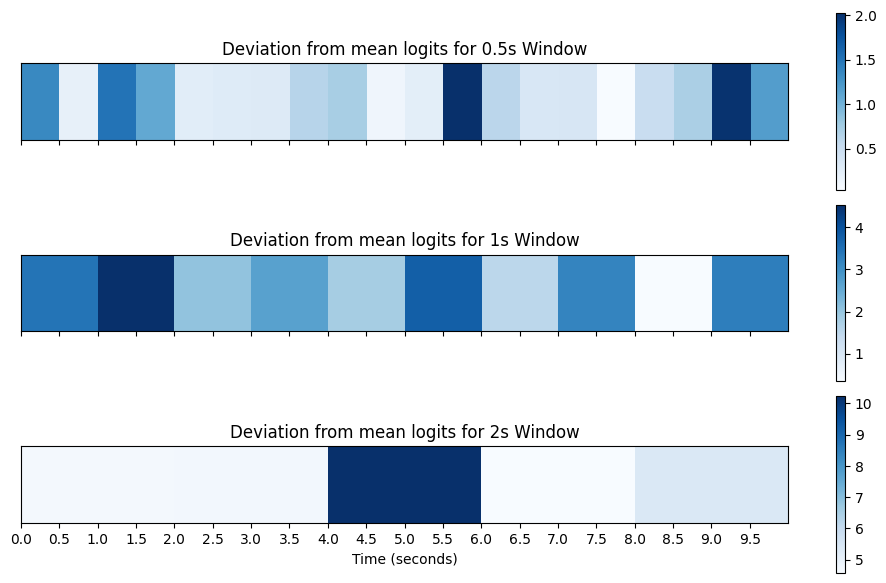

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch  # Assuming torch is needed for tensor manipulation

# Define the sample rate and signal duration
  # Duration in seconds
# Window sizes in seconds
window_sizes = [0.5, 1, 2]

# Replace these with actual loss values for each window size
loss_0_5s = torch.tensor(res['/data/users/athkulkarni/asvspoof2024/T_0000168025.flac']['0.5']['scores'])[:, 1]
loss_1s = torch.tensor(res['/data/users/athkulkarni/asvspoof2024/T_0000168025.flac']['1']['scores'])[:, 1]
loss_2s = torch.tensor(res['/data/users/athkulkarni/asvspoof2024/T_0000168025.flac']['2']['scores'])[:, 1]

# norm_loss_0_5s = (loss_0_5s - loss_0_5s.min()) / (loss_0_5s.max() - loss_0_5s.min())
# norm_loss_1s = (loss_1s - loss_1s.min()) / (loss_1s.max() - loss_1s.min())
# norm_loss_2s = (loss_2s - loss_2s.min()) / (loss_2s.max() - loss_2s.min())

# deviation_losses_0_5s = np.abs(norm_loss_0_5s - norm_loss_0_5s.mean())
# deviation_losses_1s = np.abs(norm_loss_1s - norm_loss_1s.mean())
# deviation_losses_2s = np.abs(norm_loss_2s - norm_loss_2s.mean())



deviation_losses_0_5s = np.abs(loss_0_5s - loss_0_5s.mean())
deviation_losses_1s = np.abs(loss_1s - loss_1s.mean())
deviation_losses_2s = np.abs(loss_2s - loss_2s.mean())


print(deviation_losses_0_5s.shape)
sample_rate = 16000  # Adjust as needed
signal_duration = len(loss_0_5s) * 0.5

# Normalize each loss vector (optional)


# Calculate lengths for the x-axis in terms of rectangles per window
len_0_5s = len(deviation_losses_0_5s)
len_1s = len(deviation_losses_1s)
len_2s = len(deviation_losses_2s)

# Set up a common time axis
time_axis = np.arange(0, signal_duration, 0.5)

# Convert loss vectors to 2D arrays for the heatmaps (1 x N arrays)
# deviation_losses_0_5s_2d = deviation_losses_0_5s.reshape(1, -1)
# deviation_losses_1s_2d = deviation_losses_1s.reshape(1, -1)
# deviation_losses_2s_2d = deviation_losses_2s.reshape(1, -1)


deviation_losses_0_5s_2d = deviation_losses_0_5s.unsqueeze(0)
deviation_losses_1s_2d = deviation_losses_1s.unsqueeze(0)
deviation_losses_2s_2d = deviation_losses_2s.unsqueeze(0)

# Set up subplots with a shared time axis
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
cmap = 'Blues'

# Plot each heatmap with aligned x-axis spans for proper rectangle alignment
im1 = axes[0].imshow(deviation_losses_0_5s_2d, cmap=cmap, extent=[0, signal_duration, 0, 1])
axes[0].set_title("Deviation from mean logits for 0.5s Window")
fig.colorbar(im1, ax=axes[0])
axes[0].set_yticks([])

im2 = axes[1].imshow(deviation_losses_1s_2d, cmap=cmap, extent=[0, signal_duration, 0, 1])
axes[1].set_title("Deviation from mean logits for 1s Window")
fig.colorbar(im2, ax=axes[1])
axes[1].set_yticks([])

im3 = axes[2].imshow(deviation_losses_2s_2d, cmap=cmap, extent=[0, signal_duration, 0, 1])
axes[2].set_title("Deviation from mean logits for 2s Window")
fig.colorbar(im3, ax=axes[2])
axes[2].set_yticks([])

# Single time axis with step size of 0.5 seconds for alignment
axes[2].set_xticks(time_axis)
axes[2].set_xlabel("Time (seconds)")

# Final adjustments
plt.tight_layout()
plt.show()


In [78]:
loss_0_5s

tensor([-12.0761,  -1.6634,  -0.6886,  -0.2328,  -3.9176,  -4.0187,  -3.9772,
         -6.1544,  -0.4772,  -2.1048,  -3.6822,  -2.2083,  -5.9267,  -1.2904,
         -4.3636,  -2.7338,  -0.8895,  -0.4941, -19.5119, -10.3845])

In [79]:
deviation_losses_0_5s

tensor([ 7.7363,  2.6764,  3.6512,  4.1070,  0.4222,  0.3211,  0.3626,  1.8146,
         3.8626,  2.2350,  0.6576,  2.1315,  1.5870,  3.0494,  0.0239,  1.6060,
         3.4503,  3.8457, 15.1721,  6.0447])

In [82]:
loss_0_5s

tensor([-12.0761,  -1.6634,  -0.6886,  -0.2328,  -3.9176,  -4.0187,  -3.9772,
         -6.1544,  -0.4772,  -2.1048,  -3.6822,  -2.2083,  -5.9267,  -1.2904,
         -4.3636,  -2.7338,  -0.8895,  -0.4941, -19.5119, -10.3845])

torch.Size([21])


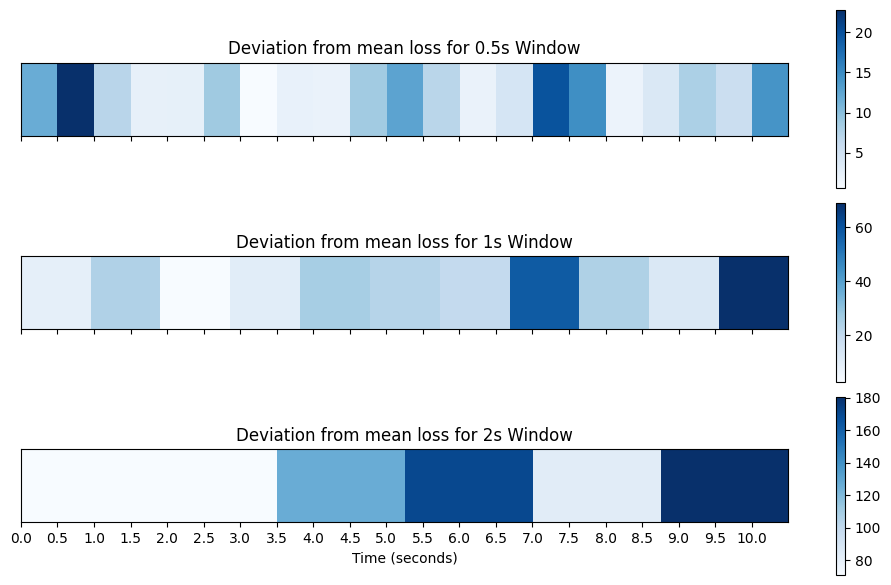

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import torch  # Assuming torch is needed for tensor manipulation

# Define the sample rate and signal duration
  # Duration in seconds
# Window sizes in seconds
window_sizes = [0.5, 1, 2]

# Replace these with actual loss values for each window size
loss_0_5s = torch.tensor(res['/data/users/athkulkarni/asvspoof2024/T_0000168025.flac']['0.5']['losses'])
loss_1s = torch.tensor(res['/data/users/athkulkarni/asvspoof2024/T_0000168025.flac']['1']['losses'])
loss_2s = torch.tensor(res['/data/users/athkulkarni/asvspoof2024/T_0000168025.flac']['2']['losses'])

# norm_loss_0_5s = (loss_0_5s - loss_0_5s.min()) / (loss_0_5s.max() - loss_0_5s.min())
# norm_loss_1s = (loss_1s - loss_1s.min()) / (loss_1s.max() - loss_1s.min())
# norm_loss_2s = (loss_2s - loss_2s.min()) / (loss_2s.max() - loss_2s.min())

# deviation_losses_0_5s = np.abs(norm_loss_0_5s - norm_loss_0_5s.mean())
# deviation_losses_1s = np.abs(norm_loss_1s - norm_loss_1s.mean())
# deviation_losses_2s = np.abs(norm_loss_2s - norm_loss_2s.mean())



deviation_losses_0_5s = np.abs(loss_0_5s - loss_0_5s.mean())
deviation_losses_1s = np.abs(loss_1s - loss_1s.mean())
deviation_losses_2s = np.abs(loss_2s - loss_2s.mean())


print(deviation_losses_0_5s.shape)
sample_rate = 16000  # Adjust as needed
signal_duration = len(loss_0_5s) * 0.5

# Normalize each loss vector (optional)


# Calculate lengths for the x-axis in terms of rectangles per window
len_0_5s = len(deviation_losses_0_5s)
len_1s = len(deviation_losses_1s)
len_2s = len(deviation_losses_2s)

# Set up a common time axis
time_axis = np.arange(0, signal_duration, 0.5)

# Convert loss vectors to 2D arrays for the heatmaps (1 x N arrays)
# deviation_losses_0_5s_2d = deviation_losses_0_5s.reshape(1, -1)
# deviation_losses_1s_2d = deviation_losses_1s.reshape(1, -1)
# deviation_losses_2s_2d = deviation_losses_2s.reshape(1, -1)


deviation_losses_0_5s_2d = deviation_losses_0_5s.unsqueeze(0)
deviation_losses_1s_2d = deviation_losses_1s.unsqueeze(0)
deviation_losses_2s_2d = deviation_losses_2s.unsqueeze(0)

# Set up subplots with a shared time axis
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
cmap = 'Blues'

# Plot each heatmap with aligned x-axis spans for proper rectangle alignment
im1 = axes[0].imshow(deviation_losses_0_5s_2d, cmap=cmap, extent=[0, signal_duration, 0, 1])
axes[0].set_title("Deviation from mean loss for 0.5s Window")
fig.colorbar(im1, ax=axes[0])
axes[0].set_yticks([])

im2 = axes[1].imshow(deviation_losses_1s_2d, cmap=cmap, extent=[0, signal_duration, 0, 1])
axes[1].set_title("Deviation from mean loss for 1s Window")
fig.colorbar(im2, ax=axes[1])
axes[1].set_yticks([])

im3 = axes[2].imshow(deviation_losses_2s_2d, cmap=cmap, extent=[0, signal_duration, 0, 1])
axes[2].set_title("Deviation from mean loss for 2s Window")
fig.colorbar(im3, ax=axes[2])
axes[2].set_yticks([])

# Single time axis with step size of 0.5 seconds for alignment
axes[2].set_xticks(time_axis)
axes[2].set_xlabel("Time (seconds)")

# Final adjustments
plt.tight_layout()
plt.show()

In [56]:
len(loss_1s)

10

In [59]:
deviation_losses_1s_2d.shape

torch.Size([1, 20])

In [58]:
len(loss_0_5s)

20

In [52]:
deviation_losses_2s_2d

tensor([[ 2.5885,  2.7343,  2.7606,  2.7626, 11.8399, 12.1853,  6.4181,  6.5337,
          3.0985,  3.4115]])

In [33]:
deviation_losses_2s_2d

tensor([[  69.2047,   68.5073, -200.1525,    0.8560,   61.5845]])

In [125]:
from IPython.display import Audio

In [129]:
Audio('/data/users/athkulkarni/asvspoof2024/T_0000164640.flac', rate=16000)

In [3]:
def saliency_map(logits_unmasked, logits_1, logits_2, logits_3):
    dev_1 = np.abs(logits_unmasked - logits_1)
    dev_2 = np.abs(logits_unmasked - logits_2)
    dev_3 = np.abs(logits_unmasked - logits_3)

    saliency_map = np.zeros(len(logits_1)* 16000) 

    for i in range(len(dev_1)):
        start = i * 16000
        end = int(start + 1 * 16000)
        
        saliency_map[start:end] = 0.2 * dev_1[i]

    for i in range(len(dev_2)):
        start = i * 16000
        end = int(start + 2 * 16000)
        saliency_map[start:end] = saliency_map[start:end] * 0.3 * dev_2[i]

    for i in range(len(dev_3)):
        start = i * 16000
        end = int(start + 3 * 16000)
        saliency_map[start:end] = saliency_map[start:end] * 0.5 * dev_3[i]
    
    return saliency_map

In [2]:
import json

res = json.load(open('/data/users/athkulkarni/lightweight_audio_masking/emotion_recognition_results 3.json'))

In [10]:
import numpy as np

In [14]:
from IPython.display import Audio

In [15]:
Audio('/data/data/Emotion-Recognition-Datasets/CREMA-D/AudioWAV/1050_IOM_DIS_XX.wav')

In [10]:
audio, sr = torchaudio.load('/data/data/Emotion-Recognition-Datasets/CREMA-D/AudioWAV/1050_IOM_DIS_XX.wav')

In [12]:
audio.shape

torch.Size([1, 42709])

In [6]:
entry = res['data/emorec/crema-d/1050_IOM_DIS_XX.wav']


In [21]:
entry['predicted_class_id']

2

In [11]:
entry['unmasked_logits'][entry['predicted_class_id']]

0.03154471144080162

In [7]:
logits_unmasked = entry['unmasked_logits'][entry['predicted_class_id']]
logits_1 = np.array(entry['window_data']['1']['logits'])[:,[entry['predicted_class_id']]]
logits_2 = np.array(entry['window_data']['2']['logits'])[:,[entry['predicted_class_id']]]
logits_3 = np.array(entry['window_data']['3']['logits'])[:,[entry['predicted_class_id']]]

In [8]:
map = saliency_map(logits_unmasked, logits_1, logits_2, logits_3)

In [9]:
map.shape

(48000,)

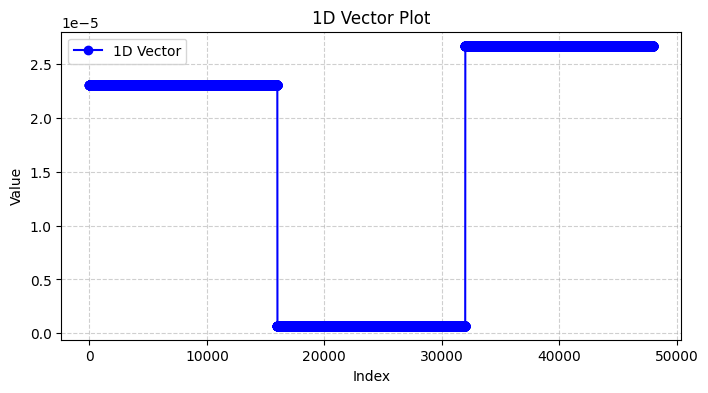

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 4))
plt.plot(map, marker='o', linestyle='-', color='b', label='1D Vector')

# Add labels and title
plt.title("1D Vector Plot")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

In [4]:
def listen_to_saliency_map(logits_no_mask, logits_1, logits_2, logits_3):
    norm_logits_1 = (logits_1 - logits_1.min()) / (logits_1.max() -  logits_1.min())
    norm_logits_2 = (logits_2 - logits_2.min()) / (logits_2.max() - logits_2.min())
    norm_logits_3 = (logits_3 - logits_3.min()) / (logits_3.max() - logits_3.min())
 
    mean_logits_no_mask = logits_no_mask.mean()

    mean_logits1 = norm_logits_1.mean()
    mean_logits2 = norm_logits_2.mean()
    mean_logits3 = norm_logits_3.mean()

    deviation_logits_1 = abs(norm_logits_1 - mean_logits1)
    deviation_logits_2 = abs(norm_logits_2 - mean_logits2)
    deviation_logits_3 = abs(norm_logits_3 - mean_logits3)

    saliency_map = np.zeros(len(norm_logits_2)* 16000) 
    print(saliency_map)
    for i in range(len(deviation_logits_1)):
        start = i * 16000
        end = int(start + 0.5 * 16000)
        
        saliency_map[start:end] = 0.2 * deviation_logits_1[i]

    for i in range(len(deviation_logits_2)):
        start = i * 16000
        end = int(start + 1 * 16000)
        saliency_map[start:end] = 0.3 * deviation_logits_2[i]

    for i in range(len(deviation_logits_3)):
        start = i * 16000
        end = int(start + 2 * 16000)
        saliency_map[start:end] = 0.5 * deviation_logits_3[i]
    
    return saliency_map

In [116]:
loss_0_5s = torch.tensor(res['/data/users/athkulkarni/asvspoof2024/T_0000168025.flac']['0.5']['scores'])
loss_1s = torch.tensor(res['/data/users/athkulkarni/asvspoof2024/T_0000168025.flac']['1']['scores'])
loss_2s = torch.tensor(res['/data/users/athkulkarni/asvspoof2024/T_0000168025.flac']['2']['scores'])

In [88]:
loss_0_5s

tensor([[ 2.1448, -2.5639],
        [ 0.5229, -1.0175],
        [-0.6270,  0.2915],
        [-0.1937, -0.1399],
        [ 1.1670, -1.4749],
        [ 1.1574, -1.5022],
        [ 1.0739, -1.5205],
        [ 1.4932, -1.8418],
        [ 0.0964, -0.5013],
        [ 0.7851, -1.0957],
        [ 1.0367, -1.4609],
        [-1.1224,  0.8068],
        [ 1.4280, -1.8201],
        [ 0.5099, -0.8738],
        [ 1.1868, -1.5727],
        [ 0.8783, -1.2591],
        [ 0.3897, -0.7182],
        [ 0.1283, -0.5146],
        [ 2.8489, -3.2167],
        [ 1.9344, -2.3964]])

In [117]:
map = listen_to_saliency_map(loss_0_5s[:,1], loss_1s[:,1], loss_2s[:,1])

[0. 0. 0. ... 0. 0. 0.]


In [92]:
import seaborn as sns

max(map)

0.3277328610420227

In [93]:
min(map)

0.013152302242815495

In [147]:
map.shape

(128000,)

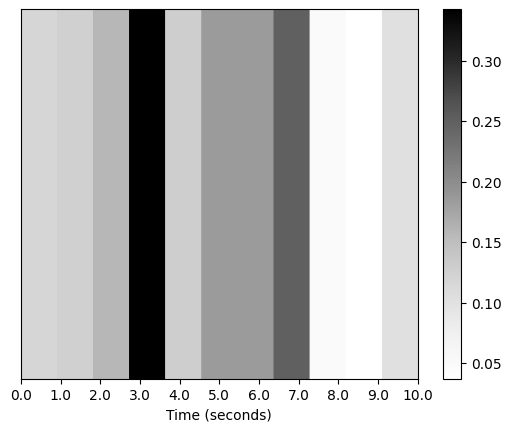

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Example vector data
vector = map  # Replace with your actual data

# Reshape vector to 2D for heatmap display
vector_2d = vector.reshape(1, -1)

# Plot heatmap with 'Greys' colormap
fig, ax = plt.subplots()
im = ax.imshow(vector_2d, aspect='auto', cmap='Greys')

# Define sampling rate and calculate time labels
sampling_rate = 16000  # in Hz
num_samples = vector.shape[0]
duration = num_samples / sampling_rate  # duration in seconds
time_labels = np.arange(0, duration, 1)  # every second

# Set x-axis ticks for time
num_ticks = len(time_labels)
ax.set_xticks(np.linspace(0, num_samples, num=num_ticks))
ax.set_xticklabels(time_labels)
ax.set_xlabel("Time (seconds)")

# Hide y-axis ticks
ax.get_yaxis().set_visible(False)

# Add color bar
fig.colorbar(im, ax=ax)

plt.show()


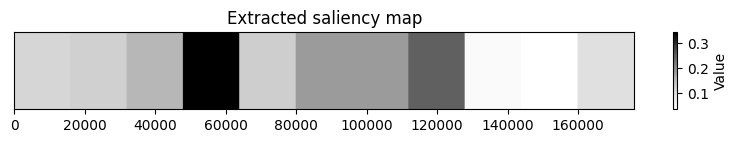

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Example vector (replace this with your data)
vector = map  # Random data for illustration

# Reshape the vector to 2D for heatmap plotting
vector_2d = vector.reshape(1, -1)  # 1 row, as many columns as elements in the vector

# Create the heatmap
plt.figure(figsize=(10, 1))  # Set the figure size for a horizontal heatmap
plt.imshow(vector_2d, aspect='auto', cmap='Greys')  # 'viridis' is the color map
plt.colorbar(label='Value')  # Add a color bar to show the value scale
# Adjust ticks and labels
plt.yticks([])  # Hide y-axis ticks since it’s a single row
plt.title("Extracted saliency map")
sampling_rate = 16000  # in Hz
num_samples = vector.shape[0]
duration = num_samples / sampling_rate  # duration in seconds
time_labels = np.arange(0, duration, 1)  # every second

# Set x-axis ticks for ti
plt.show()


In [111]:
len(map)

160000

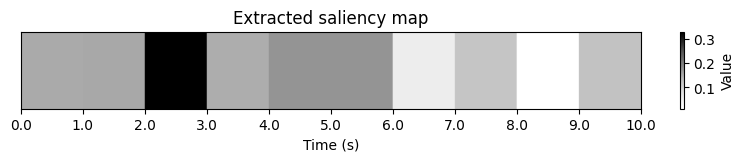

In [109]:
import numpy as np
import matplotlib.pyplot as plt

# Example vector (replace this with your data)
vector = map  # Replace 'map' with the actual data you want to plot

# Reshape the vector to 2D for heatmap plotting
vector_2d = vector.reshape(1, -1)  # 1 row, as many columns as elements in the vector

# Define sampling rate and calculate duration
sampling_rate = 16000  # in Hz
num_samples = vector.shape[0]
duration = num_samples / sampling_rate  # duration in seconds

# Create the heatmap
plt.figure(figsize=(10, 1))  # Set the figure size for a horizontal heatmap
plt.imshow(vector_2d, aspect='auto', cmap='Greys')
plt.colorbar(label='Value')  # Add a color bar to show the value scale

# Set x-axis ticks and labels
time_labels = np.arange(0, duration + 1, 1)  # every second up to the duration
plt.xticks(ticks=np.linspace(0, num_samples, len(time_labels)), labels=time_labels)  # set ticks and labels
plt.yticks([])  # Hide y-axis ticks since it’s a single row

# Add title and show the plot
plt.title("Extracted saliency map")
plt.xlabel("Time (s)")
plt.show()


In [154]:
wav, sr = torchaudio.load('/data/users/athkulkarni/asvspoof2024/T_0000132394.flac')

wav = wav.numpy()

wav.shape

(1, 119808)

In [155]:
wav.max()

0.2295227

In [156]:
wav.min()

-0.17919922

In [148]:
Audio(wav.squeeze(0), rate=16000)

In [158]:
map > 0.1

array([ True,  True,  True, ..., False, False, False])

In [149]:
Audio(wav.squeeze(0) * map[:119808], rate=16000)